In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import xlsxwriter
import xlrd 
import pandas as pd
import difflib
import numpy as np


def vectorize_dataset(file):
    #Extract excel sheet
    wb = xlrd.open_workbook(file) 
    sheet = wb.sheet_by_index(0) 
    sheet.cell_value(0,0)

# For row 0 and column 0 
#sheet.cell_value(0, 0) 
    gene_annotation = []
    gene_names = []
    for i in range(0,sheet.nrows): 
        for j in range(0,1):
            gene_annotation.append(sheet.cell_value(i, j-1))
            gene_names.append(sheet.cell_value(i, j))                                                                                                                                                                                  
    return [gene_annotation, gene_names]

gene_annotation, gene_names = vectorize_dataset(r"C:\Users\RV1030\Downloads\dataset.xlsx")

def similarity(gene_annotation, gene_names):
    vect = TfidfVectorizer(min_df=1, stop_words="english")                                                                                                                                                                                                   
    tfidf = vect.fit_transform(gene_annotation)

    pairwise_similarity = tfidf * tfidf.T 
    similarity = pairwise_similarity.toarray()
    
    #Considering similarity threshold to be 60%
    for i in similarity:
        for j in range(len(similarity)):
            i[j] = 1.0 if (i[j] >= 0.6) else 0.0
            
       
    df_p = pd.DataFrame(similarity).T
    df_p.columns =gene_names
    df_p.index= gene_names
    #Forming 1-0 matrix , value 1 indicates that the intercepting genes have similarity
    df_p.to_excel(excel_writer = "array_ps.xlsx")
    
    
similarity(gene_annotation, gene_names)


def cosine_similarity_detection(gene_annotation, gene_names):
    # Create the Document Term Matrix
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform(gene_annotation)

    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(doc_term_matrix, columns=count_vectorizer.get_feature_names())
    cosine_similarity_array = cosine_similarity(df, df)
    for i in cosine_similarity_array:
         for j in range(len(cosine_similarity_array)):
            i[j] = 1.0 if (i[j] >= 0.6) else 0.0
    df_p = pd.DataFrame(cosine_similarity_array).T
    df_p.columns =gene_names
    df_p.index= gene_names
    #Forming 1-0 matrix , value 1 indicates that the intercepting genes have similarity
    df_p.to_excel(excel_writer = "array_cs.xlsx")
    
cosine_similarity_detection(gene_annotation, gene_names)

    

def jaccard_similarity(gene_annotation, gene_names):
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform(gene_annotation)
    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(doc_term_matrix, columns=count_vectorizer.get_feature_names())
    raw_jaccard_distance =pdist(df, 'jaccard')
    distance = pd.DataFrame(squareform(raw_jaccard_distance), index=df.index, columns= df.index)

    for i in range(18):
        for j in range(18):
            distance[i][j]=1 - distance[i][j]
            distance[i][j] = 1.0 if (distance[i][j] >= 0.6) else 0.0

    df_j = pd.DataFrame(distance).T
    df_j.columns, df_j.index = gene_names, gene_names
    df_j.to_excel(excel_writer = "jaccards__4.xlsx")
    
jaccard_similarity(gene_annotation, gene_names)


def difflib_sequenceMatcher(gene_annotation, gene_names):
    #SequenceMatcher computes and caches detailed information
    #about the second sequence, so if you want to compare one
    #sequence against many sequences, use set_seq2() to set
    #the commonly used sequence once and call set_seq1()
    #repeatedly, once for each of the other sequences.

    matcher = difflib.SequenceMatcher(None)
    similarity_matrix = [[]]*len(gene_annotation)
    row = 0
    for annotation in gene_annotation:
        matcher.set_seq2(annotation)
        similarity_row = []*len(gene_annotation)
        for each_term in (gene_annotation):
            matcher.set_seq1(each_term)
            similarity_row.append(1) if (matcher.ratio() >= 0.6) else similarity_row.append(0)
        similarity_matrix[row].append(similarity_row)  
        row+=1        
    df_j = pd.DataFrame(similarity_matrix[0]).T
    df_j.columns =gene_names
    df_j.index= gene_names
    df_j.to_excel(excel_writer = "difflib.xlsx")    
    
difflib_sequenceMatcher(gene_annotation, gene_names)


def levenshtein_ratio_and_distance(first_term ,second_term):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(first_term)+1
    cols = len(second_term)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if first_term[row-1] == second_term[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                cost = 2
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    
    # Computation of the Levenshtein Distance Ratio
    Ratio = ((len(first_term)+len(second_term)) - distance[row][col]) / (len(first_term)+len(second_term))
    return Ratio
    

def levenhtein_distance_method(gene_annotation, gene_names):
    leven_matrix = [[]]*len(gene_annotation)
    row=0
    for annotation in gene_annotation:
        leven_row = []*len(gene_annotation)
        for each_gene_annotation in gene_annotation:
            Ratio = levenshtein_ratio_and_distance(annotation,each_gene_annotation)
            leven_row.append(1) if(Ratio >= 0.6)else leven_row.append(0)

        leven_matrix[row].append(leven_row)
        row+=1    

    df_l = pd.DataFrame(leven_matrix[0]).T
    df_l.columns =gene_names
    df_l.index= gene_names
    df_m = df_l.values.tolist()
    #df_l.to_excel(excel_writer = "leven2.xlsx")   
    return leven_matrix
    


In [93]:
def eigenvector_centrality(G, max_iter=100, tol=1.0e-6, nstart=None,
                           weight='weight'):
   
    from math import sqrt
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise nx.NetworkXException("Not defined for multigraphs.")

    if len(G) == 0:
        raise nx.NetworkXException("Empty graph.")

    if nstart is None:
        # choose starting vector with entries of 1/len(G)
        x = dict([(n,1.0/len(G)) for n in G])
    else:
        x = nstart
    # normalize starting vector
    s = 1.0/sum(x.values())
    for k in x:
        x[k] *= s
    nnodes = G.number_of_nodes()
    # make up to max_iter iterations
    for i in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast, 0)
        # do the multiplication y^T = x^T A
        for n in x:
            for nbr in G[n]:
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)
        # normalize vector
        try:
            s = 1.0/sqrt(sum(v**2 for v in x.values()))
        # this should never be zero?
        except ZeroDivisionError:
            s = 1.0
        for n in x:
            x[n] *= s
        # check convergence
        err = sum([abs(x[n]-xlast[n]) for n in x])
        if err < nnodes*tol:
            return x

    raise nx.NetworkXError("""eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))""")



In [82]:
def eigenvector_centrality(G, max_iter=100, tol=1.0e-6, nstart=None,
                           weight='weight'):
   
    from math import sqrt
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph:
        raise nx.NetworkXException("Not defined for multigraphs.")

    if len(G) == 0:
        raise nx.NetworkXException("Empty graph.")

    if nstart is None:
        # choose starting vector with entries of 1/len(G)
        x = dict([(n,1.0/len(G)) for n in G])
    else:
        x = nstart
    # normalize starting vector
    s = 1.0/sum(x.values())
    for k in x:
        x[k] *= s
    nnodes = G.number_of_nodes()
    # make up to max_iter iterations
    for i in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast, 0)
        # do the multiplication y^T = x^T A
        for n in x:
            for nbr in G[n]:
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)
        # normalize vector
        try:
            s = 1.0/sqrt(sum(v**2 for v in x.values()))
        # this should never be zero?
        except ZeroDivisionError:
            s = 1.0
        for n in x:
            x[n] *= s
        # check convergence
        err = sum([abs(x[n]-xlast[n]) for n in x])
        if err < nnodes*tol:
            return x

    raise nx.NetworkXError("""eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))""")


# In[85]:



def edge_current_flow_betweenness_centrality(G, normalized=True,
                                             weight='weight',
                                             dtype=float, solver='full'):

    from networkx.utils import reverse_cuthill_mckee_ordering
    try:
        import numpy as np
    except ImportError:
        raise ImportError('current_flow_betweenness_centrality requires NumPy ',
                          'http://scipy.org/')
    try:
        import scipy
    except ImportError:
        raise ImportError('current_flow_betweenness_centrality requires SciPy ',
                          'http://scipy.org/')
    if G.is_directed():
        raise nx.NetworkXError('edge_current_flow_betweenness_centrality ',
                               'not defined for digraphs.')
    if not nx.is_connected(G):
        raise nx.NetworkXError("Graph not connected.")
    n = G.number_of_nodes()
    ordering = list(reverse_cuthill_mckee_ordering(G))
    # make a copy with integer labels according to rcm ordering
    # this could be done without a copy if we really wanted to
    H = nx.relabel_nodes(G,dict(zip(ordering,range(n))))
    betweenness=(dict.fromkeys(H.edges(),0.0))
    if normalized:
        nb=(n-1.0)*(n-2.0) # normalization factor
    else:
        nb=2.0
    for row,(e) in flow_matrix_row(H, weight=weight, dtype=dtype,
                                   solver=solver):
        pos=dict(zip(row.argsort()[::-1],range(1,n+1)))
        for i in range(n):
            betweenness[e]+=(i+1-pos[i])*row[i]
            betweenness[e]+=(n-i-pos[i])*row[i]
        betweennes

[('INCENP', 'CDCA8'), ('INCENP', 'CENPN'), ('CDC20', 'ANAPC10'), ('ANAPC10', 'CDC20'), ('CDCA8', 'INCENP'), ('CENPN', 'INCENP')]
{'INCENP': 0, 'CDCA8': 0, 'CENPN': 0, 'CDC20': 0, 'ANAPC10': 0}
2
Centrality Degree
{'INCENP': 0.5, 'CDCA8': 0.25, 'CENPN': 0.25, 'CDC20': 0.25, 'ANAPC10': 0.25}
Close Centrality
{'INCENP': 0.5, 'CDCA8': 0.3333333333333333, 'CENPN': 0.3333333333333333, 'CDC20': 0.25, 'ANAPC10': 0.25}
Betweeness centrality
{'INCENP': 0.16666666666666666, 'CDCA8': 0.0, 'CENPN': 0.0, 'CDC20': 0.0, 'ANAPC10': 0.0}
eigenvector_centrality
{'INCENP': 0.7071067811066628, 'CDCA8': 0.49999999994351296, 'CENPN': 0.49999999994351296, 'CDC20': 1.0628924235733579e-05, 'ANAPC10': 1.0628924235733579e-05}


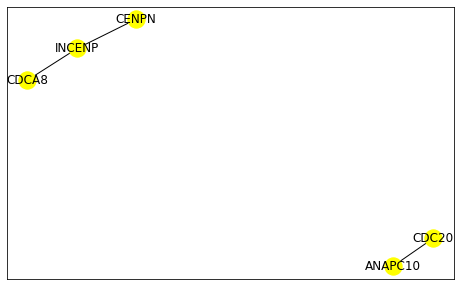

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.centrality.flow_matrix import *

def ppi_network(matrix, gene_names):
    G = nx.Graph() 
    Go = nx.Graph()
    list = []
    for row in range(len(matrix)):
        for col in range(len(matrix)):
            if matrix[row][col]==1:
                if not (gene_names[row]==gene_names[col]):
                    list.append((gene_names[row],gene_names[col]))
    plt.figure(figsize =(8,5))
    G.add_edges_from(list)
    nx.draw_networkx(G, with_labels = True, node_color ='yellow') 

    print(list)
    print(nx.clustering(G)) 
    # returns number of different connected components 
    print(nx.number_connected_components(G)) 

    # returns list of nodes in different connected components 
    m = tuple(nx.connected_components(G))
    nx.draw_networkx(Go, with_labels = True, node_color ='yellow') 
    deg_centrality = nx.degree_centrality(G) 
    print ("Centrality Degree") 
    print(deg_centrality) 
    
    close_centrality = nx.closeness_centrality(G) 
    print("Close Centrality")
    print(close_centrality)
    
    bet_centrality = nx.betweenness_centrality(G,normalized = True,endpoints = False) 
    print("Betweeness centrality")
    print(bet_centrality)
    
    eigen_centrality = nx.eigenvector_centrality(G)
    print("eigenvector_centrality")
    print(eigen_centrality)

ppi_network(levenhtein_distance_method(gene_annotation, gene_names)[0], gene_names)